# 波动率分析

In [1]:
import os
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("bmh")

读取数据

In [2]:
def read_binance_annual_ohlcv(year: int) -> pd.DataFrame:
    filepath = os.path.join("../data", f"binance_daily_ohlcv_{year}.csv")
    return pd.read_csv(filepath, index_col="timestamp", parse_dates=True)


years = [2022, 2023, 2024]
ohlcv = pd.concat((read_binance_annual_ohlcv(year) for year in years))

ohlcv

,open,high,low,close,volume,symbol
timestamp,,,,,,
2022-01-01,46216.9300,47954.6300,46208.3700,47722.6500,1.960446e+04,BTC/USDT
2022-01-02,47722.6600,47990.0000,46654.0000,47286.1800,1.834046e+04,BTC/USDT
2022-01-03,47286.1800,47570.0000,45696.0000,46446.1000,2.766208e+04,BTC/USDT
2022-01-04,46446.1000,47557.5400,45500.0000,45832.0100,3.549141e+04,BTC/USDT
2022-01-05,45832.0100,47070.0000,42500.0000,43451.1300,5.178412e+04,BTC/USDT
...,...,...,...,...,...,...
2024-04-05,0.2961,0.2989,0.2780,0.2936,9.776790e+06,BAT/USDT
2024-04-06,0.2936,0.2991,0.2918,0.2964,3.313721e+06,BAT/USDT
2024-04-07,0.2963,0.3030,0.2954,0.3023,5.018225e+06,BAT/USDT


计算历史标准差

- 选择货币对和样本
- 根据价格或者收益率来计算波动率
- 画波动率图

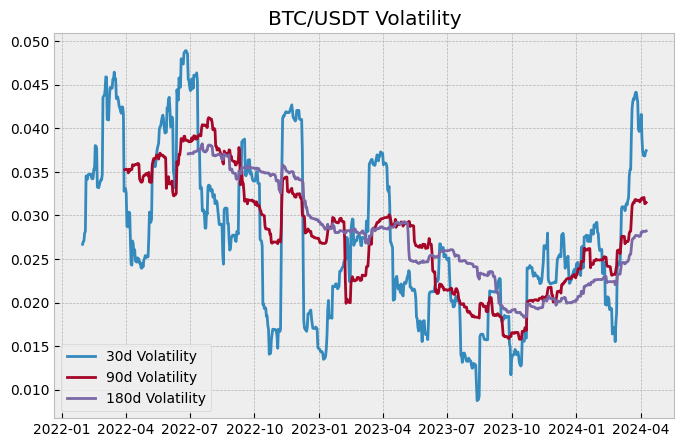

In [3]:
# 设置参数
ticker = "BTC/USDT"
start_date = dt.datetime(2022, 1, 1)
end_date = dt.datetime(2024, 4, 30)
price_volatility = False  # True if you want to calculate price volatility, False if you want return volatility

# 选择数据
ohlcv_ticker = ohlcv.query("symbol == @ticker").loc[start_date:end_date].copy()
ohlcv_ticker["daily_return"] = ohlcv_ticker["close"].pct_change().fillna(0)
series = ohlcv_ticker["close"] if price_volatility else ohlcv_ticker["daily_return"]

# 计算不同滚动窗口的波动率
vol_30d = series.rolling(window=30).std()
vol_90d = series.rolling(window=90).std()
vol_180d = series.rolling(window=180).std()

# 数据可视化
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(vol_30d, label="30d Volatility")
ax.plot(vol_90d, label="90d Volatility")
ax.plot(vol_180d, label="180d Volatility")
ax.set_title(f"{ticker} Volatility")
_ = ax.legend()

应用GARCH模型预测波动率

In [4]:
import warnings
import arch
from arch import arch_model

warnings.filterwarnings("ignore")

In [5]:
def auto_garch(y: pd.Series) -> arch.univariate.base.ARCHModelResult:
    """创建GARCH模型，自动寻找最优的p和q参数，基于AIC最小原则"""
    best_aic = np.inf
    best_model = None
    pq_range = range(5)

    for p in pq_range:
        for q in pq_range:
            try:
                tmp_model = arch_model(
                    y,
                    mean="Constant",
                    vol="GARCH",
                    p=p,
                    q=q,
                    dist="t",
                ).fit(disp="off", show_warning=False)
                aic = tmp_model.aic
                if aic < best_aic:
                    best_aic = aic
                    best_model = tmp_model
            except:
                continue

    return best_model

In [6]:
# 参数
ticker = "BTC/USDT"
forecast_start_date = dt.datetime(2023, 10, 1)
forecast_end_date = dt.datetime(2024, 4, 9)
train_window = 365

# 计算日收益率
ohlcv_ticker = ohlcv.query("symbol == @ticker").copy()
daily_return = ohlcv_ticker["close"].pct_change().dropna()

# 用GARCH模型预测波动率
forecast_vols = []
dates = pd.date_range(forecast_start_date, forecast_end_date, freq="D")
for d in dates:
    y_end_date = d - dt.timedelta(days=1)  # 使用截止到前一天的train_window天数据
    y_start_date = d - dt.timedelta(days=train_window)
    y = daily_return.loc[y_start_date:y_end_date]
    model = auto_garch(y)
    forecast_variance = model.forecast(horizon=1).variance.iloc[-1, 0]
    forecast_vol = np.sqrt(forecast_variance)  # GARCH模型的预测结果是条件方差，需要开方得到标准差，跟日收益率单位一致
    print(f"Forecast volatility for {d.date()}: {forecast_vol:.2%}")
    forecast_vols.append(forecast_vol)

Forecast volatility for 2023-10-01: 1.94%
Forecast volatility for 2023-10-02: 4.15%
Forecast volatility for 2023-10-03: 2.78%
Forecast volatility for 2023-10-04: 1.93%
Forecast volatility for 2023-10-05: 2.35%
Forecast volatility for 2023-10-06: 2.37%
Forecast volatility for 2023-10-07: 2.68%
Forecast volatility for 2023-10-08: 2.05%
Forecast volatility for 2023-10-09: 1.99%
Forecast volatility for 2023-10-10: 2.25%
Forecast volatility for 2023-10-11: 2.11%
Forecast volatility for 2023-10-12: 2.66%
Forecast volatility for 2023-10-13: 2.01%
Forecast volatility for 2023-10-14: 2.03%
Forecast volatility for 2023-10-15: 1.99%
Forecast volatility for 2023-10-16: 2.26%
Forecast volatility for 2023-10-17: 4.95%
Forecast volatility for 2023-10-18: 2.15%
Forecast volatility for 2023-10-19: 2.13%
Forecast volatility for 2023-10-20: 2.48%
Forecast volatility for 2023-10-21: 3.61%
Forecast volatility for 2023-10-22: 2.24%
Forecast volatility for 2023-10-23: 2.16%
Forecast volatility for 2023-10-24

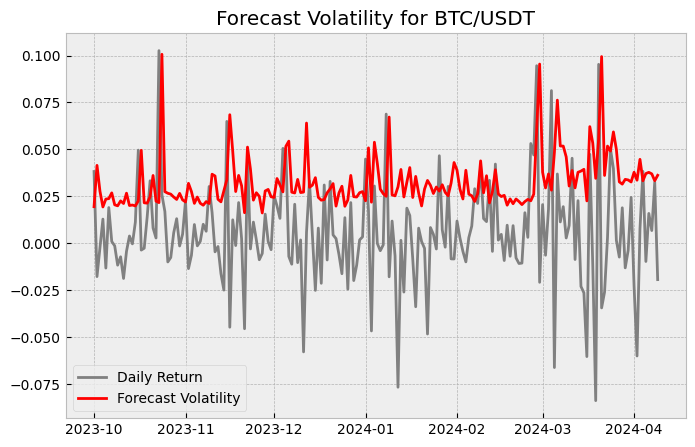

In [7]:
forecast_vols_series = pd.Series(forecast_vols, index=dates)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(daily_return.loc[forecast_start_date:forecast_end_date], label="Daily Return", color="grey")
ax.plot(forecast_vols_series, label="Forecast Volatility", color="red")
ax.set_title(f"Forecast Volatility for {ticker}")
_ = ax.legend()